In [1]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#train = pd.read_csv('Joel\\datasets\\sds\\train.csv')
#test = pd.read_csv('Joel\\datasets\\sds\\test.csv')
train = pd.read_csv('Joel\\datasets\\sds\\train_more_balanced.csv')
test = pd.read_csv('Joel\\datasets\\sds\\test_more_balanced.csv')

# Utility Functions



Before we start exploring embeddings lets write a couple of helper functions to run Logistic Regression and calculate evaluation metrics

Since we want to optimize our model for F1-Scores, for all models we'll first predict the probability of the positive class. We'll then use these probabilities to get the Precision-Recall curve and from here we can select a threshold value that has the highest F1-score. To predict the labels we can simply use this threshold value.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
sns.set_palette("muted")
    

def calc_f1(p_and_r):
    p, r = p_and_r
    return (2*p*r)/(p+r)


# Print the F1, Precision, Recall, ROC-AUC, and Accuracy Metrics 
# Since we are optimizing for F1 score - we will first calculate precision and recall and 
# then find the probability threshold value that gives us the best F1 score

def print_model_metrics(y_test, y_test_prob, confusion = False, verbose = True, return_metrics = False):

    precision, recall, threshold = precision_recall_curve(y_test, y_test_prob, pos_label = 1)
    
    #Find the threshold value that gives the best F1 Score
    best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
    best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]
    
    # Calulcate predictions based on the threshold value
    y_test_pred = np.where(y_test_prob > best_threshold, 1, 0)
    
    # Calculate all metrics
    f1 = f1_score(y_test, y_test_pred, pos_label = 1, average = 'binary')
    roc_auc = roc_auc_score(y_test, y_test_prob)
    acc = accuracy_score(y_test, y_test_pred)
    
    
    if confusion:
        # Calculate and Display the confusion Matrix
        cm = confusion_matrix(y_test, y_test_pred)

        plt.title('Confusion Matrix')
        sns.set(font_scale=1.0) #for label size
        sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['Neuro', 'Extra', 'Open', 'Agree', 'Cons'], yticklabels = ['Neuro', 'Extra', 'Open', 'Agree', 'Cons'], annot_kws={"size": 14}, cmap = 'Blues')# font size

        plt.xlabel('Truth')
        plt.ylabel('Prediction')
        
    if verbose:
        print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(f1, best_precision, best_recall, roc_auc, acc))
    
    if return_metrics:
        return np.array([f1, best_precision, best_recall, roc_auc, acc])

In [3]:
# Run Simple Log Reg Model and Print metrics
from sklearn.linear_model import SGDClassifier

# Run log reg 10 times and average the result to reduce prediction variance
def run_log_reg(train_features, test_features, y_train, y_test,  alpha = 1e-4, confusion = False, return_f1 = False, verbose = True):
    metrics = np.zeros(5)
    for _ in range(10):
        log_reg = SGDClassifier(loss = 'log', alpha = alpha, n_jobs = -1, penalty = 'l2')
        log_reg.fit(train_features, y_train)
        y_test_prob = log_reg.predict_proba(test_features)[:,1]
        metrics += print_model_metrics(y_test, y_test_prob, confusion = confusion, verbose = False, return_metrics = True)
    metrics /=10
    if verbose:
        print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics))
    if return_f1:
        return f1
    return log_reg



# Bag-of-Words, TF-IDF and Word Embeddings
At this point, let's test one dedicated classifier for each of the dimensions

In [4]:
y_train_neuro = np.where(train.neuro_bin.values == 1, 1, 0)
y_test_neuro = np.where(test.neuro_bin.values == 1, 1, 0)
print(y_train_neuro)

y_train_extra = np.where(train.extra_bin.values == 1, 1, 0)
y_test_extra = np.where(test.extra_bin.values == 1, 1, 0)
print(y_train_extra)

y_train_open = np.where(train.off_bin.values == 1, 1, 0)
y_test_open = np.where(test.off_bin.values == 1, 1, 0)
print(y_train_open)

y_train_agre = np.where(train.ver_bin.values == 1, 1, 0)
y_test_agre = np.where(test.ver_bin.values == 1, 1, 0)
print(y_train_agre)

y_train_cons = np.where(train.gew_bin.values == 1, 1, 0)
y_test_cons = np.where(test.gew_bin.values == 1, 1, 0)
print(y_train_cons)


[1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1
 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0]
[1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1
 0 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1]
[1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0]
[1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1
 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0]
[0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1
 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0]


## Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()
x_train = bow.fit_transform(train.text.values)
x_test = bow.transform(test.text.values)


#### Neuroticism

In [ ]:
run_log_reg(x_train, x_test, y_train_neuro, y_test_neuro)

F1: 0.693 | Pr: 0.594 | Re: 0.990 | AUC: 0.486 | Accuracy: 0.535 



SGDClassifier(loss='log', n_jobs=-1)

#### Extraversion

In [ ]:
run_log_reg(x_train, x_test, y_train_extra, y_test_extra)

F1: 0.859 | Pr: 0.867 | Re: 0.970 | AUC: 0.893 | Accuracy: 0.829 



SGDClassifier(loss='log', n_jobs=-1)

#### Openness

In [ ]:
run_log_reg(x_train, x_test, y_train_open, y_test_open)

F1: 0.610 | Pr: 0.631 | Re: 0.933 | AUC: 0.588 | Accuracy: 0.565 



SGDClassifier(loss='log', n_jobs=-1)

#### Agreeableness

In [ ]:
run_log_reg(x_train, x_test, y_train_agre, y_test_agre)

F1: 0.745 | Pr: 0.658 | Re: 0.991 | AUC: 0.417 | Accuracy: 0.600 



SGDClassifier(loss='log', n_jobs=-1)

#### Conscientousness

In [ ]:
run_log_reg(x_train, x_test, y_train_cons, y_test_cons)

F1: 0.710 | Pr: 0.631 | Re: 0.970 | AUC: 0.515 | Accuracy: 0.582 



SGDClassifier(loss='log', n_jobs=-1)

### TF-IDF
TFIDF should perform better than BoW since it uses document frequencies to normalize

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(train.text.values)
x_test = tfidf.transform(test.text.values)

print(x_test)

  (0, 1370)	0.08821526539393336
  (0, 1310)	0.13318216983583153
  (0, 1288)	0.24848931615665176
  (0, 1279)	0.17902233667286815
  (0, 1253)	0.21005360071637832
  (0, 1089)	0.22600586393570266
  (0, 1029)	0.22600586393570266
  (0, 978)	0.19768006406905833
  (0, 852)	0.12982047295793567
  (0, 795)	0.24848931615665176
  (0, 776)	0.0965069519756428
  (0, 643)	0.24848931615665176
  (0, 593)	0.09304013465667509
  (0, 583)	0.20347365811806536
  (0, 546)	0.23620633802329133
  (0, 534)	0.09304013465667509
  (0, 487)	0.19768006406905833
  (0, 457)	0.14913443305515586
  (0, 343)	0.12982047295793567
  (0, 339)	0.3006151693618367
  (0, 308)	0.18757014849542925
  (0, 273)	0.11069871761488244
  (0, 272)	0.2533019616684135
  (0, 270)	0.18608026931335017
  (0, 228)	0.09304013465667509
  :	:
  (16, 474)	0.12044825741284712
  (16, 468)	0.13243065730937706
  (16, 458)	0.16973634189100378
  (16, 457)	0.07948016157163422
  (16, 442)	0.06918692051611337
  (16, 419)	0.08798180959571071
  (16, 417)	0.132430657

#### Neuroticism

In [ ]:
run_log_reg(x_train, x_test, y_train_neuro, y_test_neuro)

F1: 0.693 | Pr: 0.594 | Re: 0.990 | AUC: 0.524 | Accuracy: 0.535 



SGDClassifier(loss='log', n_jobs=-1)

#### Extraversion

In [ ]:
run_log_reg(x_train, x_test, y_train_extra, y_test_extra)

F1: 0.781 | Pr: 0.718 | Re: 0.990 | AUC: 0.816 | Accuracy: 0.706 



SGDClassifier(loss='log', n_jobs=-1)

#### Openness

In [ ]:
run_log_reg(x_train, x_test, y_train_open, y_test_open)

F1: 0.692 | Pr: 0.789 | Re: 0.767 | AUC: 0.728 | Accuracy: 0.694 



SGDClassifier(loss='log', n_jobs=-1)

#### Agreeableness

In [ ]:
run_log_reg(x_train, x_test, y_train_agre, y_test_agre)

F1: 0.741 | Pr: 0.647 | Re: 1.000 | AUC: 0.427 | Accuracy: 0.588 



SGDClassifier(loss='log', n_jobs=-1)

#### Conscientousness

In [ ]:
run_log_reg(x_train, x_test, y_train_cons, y_test_cons)

F1: 0.717 | Pr: 0.621 | Re: 1.000 | AUC: 0.526 | Accuracy: 0.582 



SGDClassifier(loss='log', n_jobs=-1)

### Fasttext embeddings
Source: https://fasttext.cc/docs/en/pretrained-vectors.html

HINWEIS! Die Nomenklatur "Glove" im Programmcode ist nicht zutreffend! Ursprünglich war ein Training mit Glove geplant, aber es konnten keine deutschsprachigen, geeigneten vortrainierten Einbettungen gefunden bzw. unter verhältnismäßigem Aufwand trainiert oder eingebunden werden. Eine Korrektur der Benennungen über mehrere Skripts hinweg wäre in der aktuellen Entwicklungsstruktur fehleranfällig und aufwendig und würde daher erst vor einer potentiellen Veröffentlichung durchgeführt werden.

Die vortrainierten Einbettungen sind fasttext Modelle von Facebook (s. URL oben)

In [ ]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r', encoding="utf8") as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model


In [ ]:
#glove = load_glove_model("Joel\\vectors\\glove_german.txt")

-> VERALTET! Hat nicht funktioniert! Weiter gehts bei FastText weiter unten.

Word2Vec (Source: https://devmount.github.io/GermanWordEmbeddings/ )


In [ ]:
from gensim.models import KeyedVectors

#vecs = KeyedVectors.load_word2vec_format('Joel\\vectors\\glove_german_vectors.txt', fvocab='Joel\\vectors\\glove_german_vocab.txt', binary=False, no_header=True)
from gensim.models import Word2Vec

#model = Word2Vec.load("Joel\\vectors\\word2vec_german.model", binary=True)
#vecs = KeyedVectors.load_word2vec_format('Joel\\vectors\\word2vec_german.model', binary=True)

In [ ]:
#vecs.get_index("Kind")

In [ ]:
# We'll use Average Glove here 
from tqdm import tqdm_notebook
from nltk import word_tokenize


def avg_word2vec(df):
  vectors = []
  for text in tqdm_notebook(df.text.values):
    try:
      vectors.append(np.average(vecs.get_index(str(word)), axis = 0))
    except:
      print(str(word_tokenize(text)) + " not in embedding model")
  return np.array(vectors)

#x_train = avg_word2vec(train)
#x_test = avg_word2vec(test)


In [ ]:
#run_log_reg(x_train, x_test, y_train_neuro, y_test_neuro)

It seems this WordEmbeddings model isnt adjusted for capitalization. 

In [ ]:
#train["text_processed"] = train['text'].str.replace('[^\w\s]',' ')
#test["text_processed"] = test['text'].str.replace('[^\w\s]',' ')

#train["text_processed"] = train["text_processed"].str.lower()
#test["text_processed"] = test["text_processed"].str.lower()

In [ ]:
#train.head()

In [ ]:
#x_train = avg_word2vec(train)
#x_test = avg_word2vec(test)

## Fasttext 
(Source Facebook: https://fasttext.cc/docs/en/pretrained-vectors.html )
Preconverted Vectors into Magnitude: python -m pymagnitude.converter -i wiki.de.vec -o wiki.de.vec.magnitude

In [ ]:
from pymagnitude import *
ft = Magnitude('Joel\\vectors\\wiki.de.vec.magnitude')

In [ ]:
# We'll use Average FasText here 
from tqdm import tqdm_notebook
from nltk import word_tokenize

def avg_ft(df):
    vectors = []
    for text in tqdm_notebook(df.text.values):
        vectors.append(np.average(ft.query(word_tokenize(text)), axis = 0))
    return np.array(vectors)

x_train = avg_ft(train)
x_test = avg_ft(test)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
run_log_reg(x_train, x_test, y_train_neuro, y_test_neuro)


F1: 0.720 | Pr: 0.625 | Re: 1.000 | AUC: 0.406 | Accuracy: 0.588 



SGDClassifier(loss='log', n_jobs=-1)

In [ ]:
run_log_reg(x_train, x_test, y_train_extra, y_test_extra)


F1: 0.722 | Pr: 0.668 | Re: 0.930 | AUC: 0.586 | Accuracy: 0.624 



SGDClassifier(loss='log', n_jobs=-1)

In [ ]:
run_log_reg(x_train, x_test, y_train_open, y_test_open)


F1: 0.511 | Pr: 0.495 | Re: 0.633 | AUC: 0.729 | Accuracy: 0.624 



SGDClassifier(loss='log', n_jobs=-1)

In [ ]:
run_log_reg(x_train, x_test, y_train_agre, y_test_agre)

F1: 0.744 | Pr: 0.651 | Re: 1.000 | AUC: 0.526 | Accuracy: 0.594 



SGDClassifier(loss='log', n_jobs=-1)

In [ ]:
run_log_reg(x_train, x_test, y_train_cons, y_test_cons)

F1: 0.504 | Pr: 0.438 | Re: 0.700 | AUC: 0.506 | Accuracy: 0.535 



SGDClassifier(loss='log', n_jobs=-1)

#### Removing punctuation

In [ ]:
train_wo_punctuation = train.copy()
test_wo_punctuation = test.copy()
train_wo_punctuation["text"] = train['text'].str.replace('[^\w\s]',' ')
test_wo_punctuation["text"] = test['text'].str.replace('[^\w\s]',' ')

train_wo_punctuation.head(1)
#train["text_processed"] = train["text_processed"].str.lower()
#test["text_processed"] = test["text_processed"].str.lower()

,text,neuro_bin,extra_bin,off_bin,ver_bin,gew_bin,labels
0,In einen Technikladen an einem Museum Auf Tik...,0,1,1,1,1,"(0, 1, 1, 1, 1)"


In [ ]:
x_train = avg_ft(train_wo_punctuation)
x_test = avg_ft(test_wo_punctuation)

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
run_log_reg(x_train, x_test, y_train_neuro, y_test_neuro)

F1: 0.757 | Pr: 0.684 | Re: 0.982 | AUC: 0.671 | Accuracy: 0.629 



SGDClassifier(loss='log', n_jobs=-1)

### All lowercase

In [ ]:
train_wo_punctuation["text"] = train_wo_punctuation["text"].str.lower()
test_wo_punctuation["text"] = test_wo_punctuation["text"].str.lower()
train_wo_punctuation.head(1)

,text,neuro_bin,extra_bin,off_bin,ver_bin,gew_bin,labels
0,in einen technikladen an einem museum auf tik...,0,1,1,1,1,"(0, 1, 1, 1, 1)"


In [ ]:
x_train = avg_ft(train_wo_punctuation)
x_test = avg_ft(test_wo_punctuation)

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
run_log_reg(x_train, x_test, y_train_neuro, y_test_neuro)

F1: 0.745 | Pr: 0.658 | Re: 0.991 | AUC: 0.709 | Accuracy: 0.600 



SGDClassifier(loss='log', n_jobs=-1)

## IDF-Weighted FastText
Instead of just taking the average of each word, what if we did weighted average - in particular IDF-Weighted average?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf.fit(train.text.values)

TfidfVectorizer()

In [ ]:
# Now lets create a dict so that for every word in our corpus we have a corresponding IDF value
idf_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
print(idf_dict)

{'12': 4.481240089335692, '15': 4.481240089335692, '30uhr': 4.481240089335692, 'ab': 4.075774981227528, 'abarbeiten': 4.481240089335692, 'abbringen': 4.481240089335692, 'abend': 3.094945728215801, 'abendrot': 4.481240089335692, 'abends': 3.7880929087757464, 'aber': 2.535329940280379, 'abgesagt': 4.481240089335692, 'abholzung': 4.481240089335692, 'abhängig': 4.481240089335692, 'ablauf': 4.481240089335692, 'abschließen': 4.481240089335692, 'abschluss': 4.481240089335692, 'abschlussfeier': 4.481240089335692, 'abseits': 4.481240089335692, 'achterbahnen': 4.481240089335692, 'adventure': 4.481240089335692, 'aktives': 4.075774981227528, 'aktivierungsübung': 4.481240089335692, 'aktivität': 4.075774981227528, 'aktuell': 3.7880929087757464, 'aktuelle': 4.481240089335692, 'aktuelles': 4.481240089335692, 'albern': 4.481240089335692, 'alle': 3.5649493574615367, 'allein': 4.481240089335692, 'alleine': 4.481240089335692, 'allem': 3.5649493574615367, 'alles': 2.535329940280379, 'allgemein': 4.48124008

In [ ]:
# Same as Avg ft except instead of doing a regular average, we'll use the IDF values as weights. 

def tfidf_ft(df):
    vectors = []
    for text in tqdm_notebook(df.text.values):
        ft_vectors = ft.query(word_tokenize(text))
        weights = [idf_dict.get(word, 1) for word in word_tokenize(text)]
        vectors.append(np.average(ft_vectors, axis = 0, weights = weights))
    return np.array(vectors)

x_train = tfidf_ft(train)
x_test = tfidf_ft(test)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

#### Neuroticism

In [ ]:
run_log_reg(x_train, x_test, y_train_neuro, y_test_neuro)

F1: 0.720 | Pr: 0.625 | Re: 1.000 | AUC: 0.573 | Accuracy: 0.588 



SGDClassifier(loss='log', n_jobs=-1)

#### Extraversion

In [ ]:
run_log_reg(x_train, x_test, y_train_extra, y_test_extra)

F1: 0.695 | Pr: 0.592 | Re: 1.000 | AUC: 0.517 | Accuracy: 0.535 



SGDClassifier(loss='log', n_jobs=-1)

#### Openness

In [ ]:
run_log_reg(x_train, x_test, y_train_open, y_test_open)

F1: 0.628 | Pr: 0.615 | Re: 0.756 | AUC: 0.771 | Accuracy: 0.694 



SGDClassifier(loss='log', n_jobs=-1)

#### Agreeableness

In [ ]:
run_log_reg(x_train, x_test, y_train_agre, y_test_agre)

F1: 0.744 | Pr: 0.651 | Re: 1.000 | AUC: 0.545 | Accuracy: 0.594 



SGDClassifier(loss='log', n_jobs=-1)

#### Conscientousness

In [ ]:
run_log_reg(x_train, x_test, y_train_cons, y_test_cons)

F1: 0.710 | Pr: 0.652 | Re: 0.940 | AUC: 0.574 | Accuracy: 0.594 



SGDClassifier(loss='log', n_jobs=-1)

## Visualize IDF-Weighted Glove

In [ ]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib.pyplot as plt


tsne = TSNE(n_components = 2, n_jobs= -1, verbose = 10, perplexity = 30)
tsne_data = tsne.fit_transform(x_train)

tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['Neuroticism'] = train.neuro_bin.values

sns.scatterplot(x = 'X', y = 'Y', hue = 'Neuroticism', data = tsne_data)
plt.title('TSNE on IDF-Glove Text Encodings Neuroticism')
plt.show()

ValueError: ignored

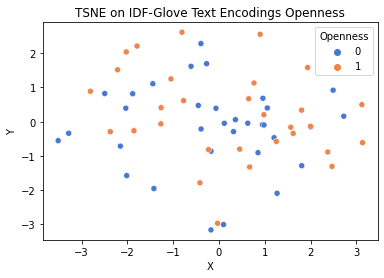

In [ ]:
tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['Openness'] = train.off_bin.values

sns.scatterplot(x = 'X', y = 'Y', hue = 'Openness', data = tsne_data)
plt.title('TSNE on IDF-Glove Text Encodings Openness')
plt.show()